In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir("../")

In [46]:
%autoreload 2
from pathlib import Path

import torch
import torch.nn as nn

import random
import math
import ot as pot
import numpy as np
from tqdm.auto import trange
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sb.nn.utils import ModelOutput
from sb.losses.utils import get_model_outputs
from sb.data.datasets import GMM, TwoMoons, SCurve
from sb.losses import compute_fwd_tlm_loss_v2, compute_bwd_tlm_loss_v2
from sb.samplers.utils import sample_trajectory_v2

In [278]:
class Net(nn.Module):
    def __init__(self, idim=3, odim=2, hdim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(idim, hdim), nn.ELU(),
            nn.Linear(hdim, hdim), nn.ELU(),
            nn.Linear(hdim, hdim), nn.ELU(),
            nn.Linear(hdim, hdim), nn.ELU(),
            nn.Linear(hdim, odim)
        )

    def forward(self, x, t):
        if t.ndim == 0:
            t = torch.ones(x.size(0), 1, device=x.device) * t
        elif t.ndim == 1:
            t = t[:, None]
        
        xt = torch.cat([x, t], dim=1) 
        out = self.net(xt)
        
        if out.size(1) == 4:
            mean, log_var = out.chunk(2, dim=1)
            return ModelOutput(drift=mean, log_var=log_var)
        return ModelOutput(drift=out)

In [302]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


@torch.no_grad()
def plot_samples(x0, x1, title0, title1, lim=(-2, 2)):
        _, a = plt.subplots(1, 2, figsize=(8, 4))
        
        a[0].scatter(*x0.cpu().T, alpha=0.5, s=2.0)
        a[0].set_title(title0)
        a[0].set_xlim(*lim)
        a[0].set_ylim(*lim)
        
        a[1].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
        a[1].set_title(title1)
        a[1].set_xlim(*lim)
        a[1].set_ylim(*lim)
        plt.show()


@torch.no_grad()
def plot_losses(fwd_losses, bwd_losses, sb_step):
    _ = plt.figure(figsize=(8, 5))
    plt.plot(bwd_losses, label='backward')
    plt.plot(fwd_losses, label='forward')
    plt.title(f'SB Iter {sb_step + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()


def make_fwd_sde_step(z, xt, dt, alpha, g):
    drift = alpha * xt + g * z
    diff = g * math.sqrt(dt)
    return xt + drift * dt + diff * torch.randn_like(xt)


def make_bwd_sde_step(z, xt, dt, alpha, g):
    drift = alpha * xt - g * z
    diff = g * math.sqrt(dt)
    return xt - drift * dt + diff * torch.randn_like(xt)


@torch.no_grad()
def generate_fwd(fwd_model, x0,
                 dt, t_max, num_steps, alpha, var,
                 method="mean", return_trajectory=False):
    if return_trajectory:
        trajectory = [x0]
    
    xt = x0.clone().to(x0.device)
    for t in torch.linspace(dt, t_max, num_steps):
        out, std = get_model_outputs(fwd_model, xt, t - dt, dt, var)
        
        if method  == "ll":
            xt = xt + out * dt + std * torch.randn_like(xt)
        elif method == "mean":
            xt = out + std * torch.randn_like(xt)
        elif method == "eot":
            xt = out + std * torch.randn_like(xt)
        elif method == "score":
            xt = xt + out + std * torch.randn_like(xt)
        elif method == "sde":
            xt = make_fwd_sde_step(out, xt, dt, alpha, var)
        else:
            raise ValueError(f"Unknown method {method}")
        
        if return_trajectory:
            trajectory.append(xt.clone())
    
    if return_trajectory:
        return trajectory
    
    return xt


@torch.no_grad()
def generate_bwd(bwd_model, x1,
                 dt, t_max, num_steps, alpha, var,
                 method="mean", return_trajectory=False):
    if return_trajectory:
        trajectory = [x1]
    
    xt = x1.clone().to(x1.device)
    for t in torch.linspace(t_max, dt, num_steps):
        t = torch.ones(xt.size(0), device=xt.device) * t
        out, std = get_model_outputs(bwd_model, xt, t, dt, var)
        
        if method  == "ll":
            xt = xt + out * dt + std * torch.randn_like(xt)
        elif method == "mean":
            xt = out + std * torch.randn_like(xt)
        elif method == "eot":
            xt = out + std * torch.randn_like(xt)
        elif method == "score":
            xt = xt + out + std * torch.randn_like(xt)
        elif method == "sde":
            xt = make_bwd_sde_step(out, xt, dt, alpha, var)
        else:
            raise ValueError(f"Unknown method {method}")

        if return_trajectory:
            trajectory.append(xt.clone())
    
    if return_trajectory:
        return trajectory
    
    return xt

In [306]:
set_seed(3845)
device = torch.device("mps")
fwd_model = Net(idim=3, odim=2).to(device)
bwd_model = Net(idim=3, odim=2).to(device)

fwd_optim = torch.optim.Adam(
    fwd_model.parameters(), 
    lr=5e-4, weight_decay=1e-8
)
bwd_optim = torch.optim.Adam(
    bwd_model.parameters(), 
    lr=5e-4, weight_decay=1e-8
)

dt = 0.01
num_proc_steps = 20
t_max = num_proc_steps * dt
method = 'sde'  # Options: 'mean', 'll', 'sde, 'score', 'eot, 'dsbm', dsbm++'

batch_size = 512
var = 1.0
num_fwd_steps = 500
num_bwd_steps = 500
num_sb_train_steps = 20


p1 = GMM(r=1, n_modes=8, noise=0.1)
data_var = p1.sample(10_000).to(device).var()
alpha = 1 / data_var

bwd_losses, fwd_losses = [], []

def reference_process(x, t):
    if method in {'mean', 'll', 'eot'}:
        return ModelOutput(drift=(1 - alpha * dt) *  x)
    if method == 'sde':
        return ModelOutput(drift=0)
    if method == 'score':
        return ModelOutput(drift=-alpha * x * dt)

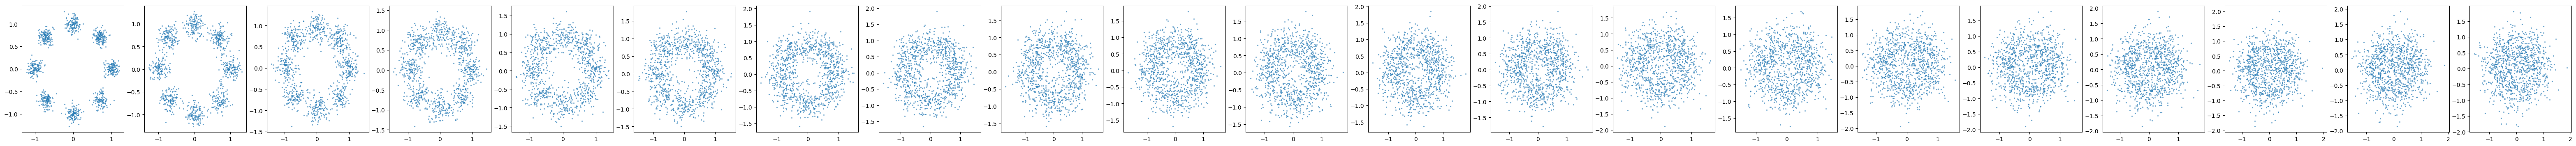

In [ ]:
x1 = p1.sample(1000).to(device)
f, a = plt.subplots(1, num_proc_steps + 1, figsize=(4 * num_proc_steps, 4))
a[0].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
for i, t in enumerate(torch.linspace(t_max, dt, num_proc_steps)):
    t = torch.ones(x1.size(0), device=x1.device) * t
    out = reference_process(x1, t)
    x1 = make_bwd_sde_step(out.drift, x1, dt, alpha, math.sqrt(var))
    a[i+1].scatter(*x1.cpu().T, alpha=0.5, s=2.0)
plt.show()

In [301]:
set_seed(3845)
for sb_step in range(num_sb_train_steps):
    # TRAINING FORWARD MODEL
    for fwd_it in trange(num_fwd_steps, leave=False, 
                         desc=f"Fwd training, SB step {sb_step + 1}"):
        fwd_optim.zero_grad(set_to_none=True)

        fwd_loss = 0
        x0 = torch.randn(batch_size, 2, device=device) * data_var.sqrt()
        x1 = p1.sample(batch_size).to(device)
        _bwd_model = reference_process if sb_step == 0 else bwd_model
        loss = compute_fwd_tlm_loss_v2(fwd_model, _bwd_model, x0, x1, 
                                       dt, t_max, num_proc_steps, alpha, var,
                                       backward=True, method=method)   
        fwd_optim.step()
        fwd_losses.append(loss.item() / num_proc_steps)

    # TRAINING BACKWARD MODEL
    for bwd_step in trange(num_bwd_steps, leave=False, 
                           desc=f"Bwd training, SB step {sb_step + 1}"):
        bwd_optim.zero_grad(set_to_none=True)
        
        x0 = torch.randn(batch_size, 2, device=device) * data_var.sqrt()
        x1 = p1.sample(batch_size).to(device)
        loss = compute_bwd_tlm_loss_v2(fwd_model, bwd_model, x0, x1,
                                       dt, t_max, num_proc_steps, alpha, var,
                                       backward=True, method=method)
        bwd_optim.step()
        bwd_losses.append(loss.item() / num_proc_steps)

    clear_output(wait=True)

    # Plotting losses
    plot_losses(fwd_losses, bwd_losses, sb_step)

    # Plotting forward sampling
    x0 = torch.randn(5000, 2, device=device) * data_var.sqrt()
    x1 = sample_trajectory_v2(fwd_model, x0, 
                              dt, t_max, num_proc_steps, alpha, var, "fwd", 
                              only_last=True, method=method)     
    plot_samples(x0, x1, 'x0 ~ p0', 'x1 ~ P_fwd(·|x0)', lim=(-2.5, 2.5))

    # Plotting backward sampling
    x1 = p1.sample(5000).to(device)
    x0 = sample_trajectory_v2(bwd_model, x1, 
                              dt, t_max, num_proc_steps, alpha, var, "bwd", 
                              only_last=True, method=method)   
    plot_samples(x1, x0, 'x1 ~ p1', 'x0 ~ P_bwd(·|x1)', lim=(-2.5, 2.5))

    plt.close('all')

Fwd training, SB step 1:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [143]:
from torch.func import jacrev, vmap, jvp
from functools import partial

In [218]:
x = torch.ones(16, 2, device=device)
t = torch.randn(16, 1, device=device)
eps = torch.randn(16, 2, device=device)

In [219]:
def model_fn(x, t):
    x, t = x.unsqueeze(0), t.unsqueeze(0)
    o = torch.cat([x.pow(2).sum(1, keepdim=True), -0.5 * x.pow(2).sum(1, keepdim=True)], dim=1)
    return o.squeeze(0)

batch_jacobian = vmap(jacrev(model_fn, argnums=0))(x, t)
trace_true = torch.vmap(torch.trace)(batch_jacobian)
trace_true

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='mps:0')